## WEEK 1:

#### terminal input: 
spades.py -o /home/be131-19/Lab_8_Nate/aligned -1 /data/lab8/illumina_reads_R1.fastq -2 /data/lab8/illumina_reads_R2.fastq --pacbio /data/lab8/pacbio_reads.fastq -t 1

Description: The command above first specifies the program, "spades.py". This program is useful for taking in reads and combining them into a complete genome. "-o" specifies the output directory, here that directory is in Lab_8_Nate and is named "aligned". "-1" specifies the path to the first Illumina read, found at "/data/lab8/illumina_reads_R1.fastq". "-2" specifies the path to the second Illumina read, found at "/data/lab8/illumina_reads_R2.fastq". The "-t 1" keyword tells the program to run on only 1 core rather than 16 so that the system is not overloaded and we all can use it. 

#### terminal output:
"======= SPAdes pipeline finished WITH WARNINGS!
=== Error correction and assembling warnings:
  0:16:42.995   564M / 1G    WARN    General (kmer_coverage_model.cpp   : 218)   Too many erroneous kmers, the estimates might be unreliable
======= Warnings saved to /home/be131-19/Lab_8_Nate/aligned.fastq/warnings.log
SPAdes log can be found here: /home/be131-19/Lab_8_Nate/aligned.fastq/spades.log
Thank you for using SPAdes!"

Description: The terminal output was long but I copied the end up it and pasted it here. It looks messy above. The important part is that the output of this command was genome information stored in a file titled "aligned" as specified by the "-o" keyword in the input code. In the folder "aligned" are various other folders and files including "scaffolds.fasta" and "contigs.fasta". This information is processed more in week 2. Spades.py complied all the reads into a complete genome described by contigs/scaffolds. 

#### Questions:

Why do we expect short reads to produce a more fragmented assembly than long reads?

Statistically speaking, it is more difficult to unambiguously construct a genome from short reads than from long reads. If a read is short, it is more difficult to determine where it should be placed relative to other reads because there is less information to be gained from overlap about where each read should be placed. The longer a read is, the more likely it is to overlap another read, so the easier it is to place and form the genome by such a construction. This is why short reads can produce a more fragmented assembly (For short reads, cannot tell how certain things connect because the overlap is lacking.)

Why does a single-molecule sequencing like PacBio have a higher error rate than Illumina?

PacBio has approximately a 13% error rate compared to Illumina's approximately 0.1% error rate. Both of these are the error rates for a single pass. Comparing the read lengths, Illumina reads are approximately 2x250 bp while on PacBio reads can range from 1 to 1.5x10^4 bp per read on average (https://www.sciencedirect.com/science/article/pii/S1672022915001345). Here, the trade off is having longer reads that will allow us to construct at a more contiguous assembly comes at the cost of a higher error rate per base pair. Conversely, having shorter reads with a lower error rate per base pair comes at the cost of constucting a more fragmented genome. Error rate in single-molecule sequencing is stocastic. The source of this error difference is the "single molecule" differentiator. Because there is only a single molecule that passes through the measurement site and the measurement is time dependent, too long of a pause in the detection zone can result in detection of an insertion when there is no insertion. Similarly, when a homopolymers pass through the detection site it is difficult to differentiate how many signals there were. (http://seqanswers.com/forums/showthread.php?t=28665). Most of these errors come from the model design which involves a dynamic model where a single molecule passes through a detection site in a time dependent manner. If the molecule does not pass through in the time expected, various types of errors arise. 



## WEEK 2: 

# Running "assembly-stats" program

#### input: assembly-stats contigs.fasta
#### output:
stats for contigs.fasta
- sum = 6678635, n = 176, ave = 37946.79, largest = 414008
- N50 = 234690, n = 11
- N60 = 202142, n = 14
- N70 = 154232, n = 18
- N80 = 103367, n = 23
- N90 = 81286, n = 30
- N100 = 128, n = 176
- N_count = 0
- Gaps = 0

__description:__ 
total length = 6678635 | number of contigs = 176 | N50 = 234690

#### input: assembly-stats scaffolds.fasta
#### output:
stats for scaffolds.fasta
- sum = 6678655, n = 174, ave = 38383.07, largest = 414008
- N50 = 234690, n = 11
- N60 = 202142, n = 14
- N70 = 154232, n = 18
- N80 = 103367, n = 23
- N90 = 81821, n = 30
- N100 = 128, n = 174
- N_count = 20
- Gaps = 2

__description:__ 
total length = 6678655 | number of scaffolds = 174 | N50 = 234690

#### Questions: 
Why is N50 is useful statistic to calculate? Why not just list the mean or median contig length?
    
N50 is similar to a mean/median of lengths but it gives more weight to longer contigs. This length weighted median gives a more robust quality value than a simple median (http://www.metagenomics.wiki/pdf/definition/assembly/n50). This is important because it means that shorter reads do not significantly pull the median/mean down and similarly with larger contigs. However, this score is still biased and attention must be given comparing N50 to the actual genome size. 

In your assembly, are scaffolds longer than contigs, or are scaffolds approximately equal to
contigs?

In this assembly, the scaffold are approximately equal in size to contigs. They have equal N50 scores but they have a greater total length with a smaller number of scaffolds than contigs. This difference is not very large though so stitching together of contigs into larger scaffolds is not indicated by these statistics. 

#### Extra Credit


In [4]:
from Bio import SeqIO
fasta_coverage = SeqIO.parse(open("/home/be131-19/Nate/Lab_8_Nate/aligned/contigs.fasta"), "fasta")
headers = []
for x in fasta_coverage:
    headers.append(x.id)

In the above cell, I opened the contigs file and appended the headers as strings to an empty list named headers. 

In [13]:
coverage = []
for y in headers:
    a = y
    cov = ''
    while not a[-1] == "_":
        cov = a[-1] + cov
        length = len(a)
        cut = length -1
        a = a[:cut]
    coverage.append(round(float(cov)))

In the above cell, I wrote something that paresed through the names of the headers and returned a string that contined the coverage of that contig. I then converted these strings to numbers which were rounded and then stored in a list titled coverage. 

In [25]:
dictionary = {}
for x in coverage:
    if x in dictionary:
        dictionary[x] += 1
    else:
        dictionary[x] = 1

def lookup(value, dictionary):
    r = 0
    if value in dictionary:
        r = dictionary[value]
        return r
    return r   

y_values = []
for x in range(1, 1600): 
    y_values.append(lookup(x, dictionary))

In the above cell, I made a dictionary by counting the number of times that we saw a coverage value in the coverage list. This number was defined as the dictionary value corresponding to a dictionary key defined as the coverage value. 

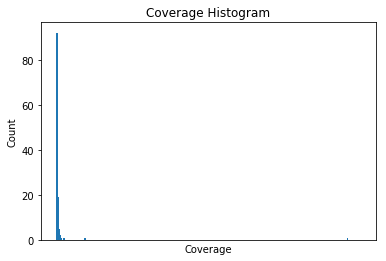

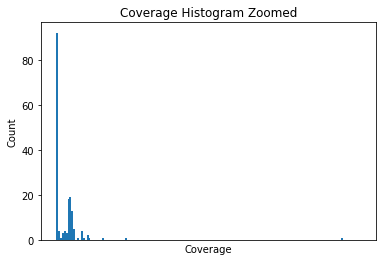

In [32]:
import numpy as np
import matplotlib.pyplot as plt

plt.bar(range(1,1600), y_values, 10)
plt.xticks([])
plt.title("Coverage Histogram")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.show()

plt.bar(range(1,160), y_values[0:159], 1)
plt.xticks([])
plt.title("Coverage Histogram Zoomed")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.show()

In the above cell, I plotted the count of coverage values against the coverage with a domain of 1 to 1599 and a domain of 1 to 158 to get a more zoomed in histogram. Observing these plots, it is clear there are many contigs with a coverage of 1. The max covarge value that we see is 1536 far to the right. 

#### Extra Credit Questions:
Is coverage uniformly distributed? Does it look Gaussian? Is it bimodal or trimodal?

Coverage is unimodal centered at 1. However, there are other peaks that are also important, particulary 1536 (the rightmost value of the first histogram). This histogram of coverage is definitely not uniformly distributed: it more closely resembles an Extreme Value Distribution histogram. This is to be expected because the rightmost value of the distribution is likely the "correct" contig. This contig (with a coverage of 1536) has a coverage so much greater than the coverage of any other contigs so we may draw conclusions from this. It is the contig that aligned to 1536 other things so it is important. It is expected that we see a high count of contigs with a coverage value of 1 because if that contig exists, then it is covered at least once. Most contigs will not be seen a secong time which is why there are so many contigs with coverage value 1. These can be thought of as single Sanger reads that didn't align to anything else. 

What explains the presence of contigs with coverage an integer multiple of the mean coverage?

Contigs with coverage an interger multiple of the mean coverage are explained by a read that overlaps with multiple subsequences of a sequence with the mean coverage. In this way, some sequences are overcounted because it appears that they are overlapping with more sequences. In reality, they are overlapping with subsequences with the same sequence. 

# Identifying taxon from which genome originated:

### Step 1: Scan over the entire genome to locate copies of the 16S ribosomal RNA gene
#### input:
rna_hmm3.py -i /home/be131-19/Lab_8_Nate/aligned/contigs.fasta-o /home/be131-19/Lab_8_Nate/rRNA.gff

#### output:
this program output a Genome Feature Format (GFF) annotation file at the specified path (/home/be131-19/Lab_8_Nate/rRNA.gff). The output file was named "rRNA.gff". 

Next, in "rRNA.gff" I visually inspected that there were eight 23S_rRNA genes, six 16S_rRNA genes, and six 5S_rRNA genes. I deleted the 23S and 5S genes directly in the GFF file, leaving behind six 16S_rRNA genes. 

### Step 2: Extract the 16S rRNA genes directly from assembly
#### input:
bedtools getfasta -fi /home/be131-19/Lab_8_Nate/aligned/contigs.fasta -bed /home/be131-19/Lab_8_Nate/rRNA.gff

#### output:
index file /home/be131-19/Lab_8_Nate/aligned/contigs.fasta.fai not found, generating...
">NODE_23_length_103367_cov_10.081286:35530-37075"
">NODE_18_length_154232_cov_9.584186:124541-126086"
">NODE_5_length_327223_cov_9.241629:46285-47830"
">NODE_6_length_298784_cov_8.918606:13925-15470"
">NODE_4_length_332509_cov_9.114046:137011-138556"
">NODE_2_length_378948_cov_10.006665:348499-350044"

Following each fasta header was the corresponding sequence, I omitted them because they were long. Instead, I stored them in a FASTA file since they were already in FASTA format. I named this file "16SrRNA.fasta". To make sure everything ran correctly, I made sure that the names of these output sequences matched the names of the 16S sequences stored in "rRNA.gff". They matched. 

### Step 3: Comparing these genes (above) to a database of known 16S rRNA genes

I pointed my browser to: https://rdp.cme.msu.edu/seqmatch/seqmatch_intro.jsp
Then I copied the FASTA formated sequences (output in the previous step) from "16SrRNA.fasta". I pasted them into the text box with the following parameters: {Strain: Both, Source: Both, Size:>1200, Quality:Good, Taxonomy:Nomenclatural, KNN matches:20}. 

The output follows: 

rootrank Root (6) (query sequences)            
     - domain Bacteria  (6) 
         - phylum "Proteobacteria"  (6) 
            - class Gammaproteobacteria  (6) 
                - order Pseudomonadales  (6) 
                   - family Pseudomonadaceae  (6) 
                      - genus Pseudomonas  (6) 
                         NODE_23_length_103367_cov_10.081286:35530-37075  
                         NODE_2_length_378948_cov_10.006665:348499-350044 
                         NODE_6_length_298784_cov_8.918606:13925-15470
                         NODE_5_length_327223_cov_9.241629:46285-47830  
                         NODE_4_length_332509_cov_9.114046:137011-138556  
                         NODE_18_length_154232_cov_9.584186:124541-126086 
                         
Genus level identification: Pseudomonas

I came to this conclusion because each of the six 16S rRNA sequences that I ran in the SeqMatch tool was identified as part of the genus Pseudomonas. It did this by comparing each of the 16S sequences to a database of high-quality curated sequences, obtained from known bacteria. Since all of the sequences ran gave the same genus, I concluded that this was the genus. 

# Genome Annotation

## RAST

RAST says "You may upload a prokaryotic genome in one or more contigs, as either a single multitrecord FASTA format file or a Genbank format file." so I uploaded "contigs.fasta" after I made an account. On the second page I indicated that the domain was Bacteria, the genus was Pseudomonas, and chose that the genetic code was 11 (for Archea, most Bacteria, most Virii, and some Mitochondria). Then I submitted the job.
RAST then gave me a job id: 653399.

Below is the resultant annotated genome:

![RAST.JPG](RAST.JPG)
http://rast.nmpdr.org/rast.cgi?page=JobDetails&job=653463

## BASys 

In BASys, I input my email into the first field, I chose "1" as the genome/contig identifier, with some research I found that bacteria in the genus Pseudomonas are gram negative (https://en.wikipedia.org/wiki/Pseudomonas_aeruginosa), I then input the genus as "Pseudomonas". I also selected that the contig is circular and chose the genetic code was bacterial. 

Below is the resultant annotated genome:

![BASys.JPG](BASys.JPG)
https://www.basys.ca/server1/basys/cache/1fe44983ae3d471262d250142087833f/index.html